In [2]:
pip install torch

     ------                                30.5/162.6 MB 779.4 kB/s eta 0:02:50
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "D:\anaconda3\envs\df\lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "D:\anaconda3\envs\df\lib\site-packages\pip\_vendor\urllib3\response.py", line 560, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "D:\anaconda3\envs\df\lib\site-packages\pip\_vendor\urllib3\response.py", line 526, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "D:\anaconda3\envs\df\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "D:\anaconda3\envs\df\lib\http\client.py", line 465, in read
    n = self.readinto(b)
  File "D:\anaconda3\envs\df\lib\http\client.py", line 509, in readinto
    n = self.fp.readinto(b)
  File "D:\anaconda3\envs\df\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "D:\anaconda3\envs\df\lib\ssl.py", line 1071, in recv_into
  

In [1]:

################################################
##
## image classification
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report


ModuleNotFoundError: No module named 'pandas'

In [3]:

#pip install mlxtend


In [2]:

#######################################################

from fastai.vision.all import *


#######################################################

N_EPOCHS = 10000          ## 4000
batch_size = 10   ## 5    ## 32
learning_rate =  0.1    ## 0.01   ## 1e-5 


#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################


ModuleNotFoundError: No module named 'fastai'


## Load Data


In [5]:

## Download SkyScanCorpus with a folder inside for each class (e.g. boeing, airbus, etc). 
## Put images in each corresponding folder

path = Path('road')


In [6]:

fns = get_image_files(path)
fns


(#2217) [Path('road/forward/004346.png'),Path('road/forward/004347.png'),Path('road/forward/004348.png'),Path('road/forward/004350.png'),Path('road/forward/004402.png'),Path('road/forward/004404.png'),Path('road/forward/004405.png'),Path('road/forward/004407.png'),Path('road/forward/004408.png'),Path('road/forward/004410.png')...]


## DataLoader


In [7]:

## This is a data loader

## parent_label -> simply gets the name of the folder a file is in

fruits = DataBlock(
     blocks = (ImageBlock, CategoryBlock),
     get_items = get_image_files,
     splitter = RandomSplitter(valid_pct=0.2, seed=42),
     get_y = parent_label,
     item_tfms = Resize(128)  ## by default it crops
)


In [8]:

dls = fruits.dataloaders(path)



## View some of the data


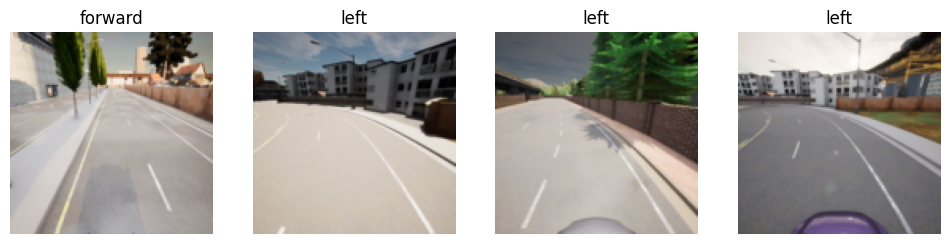

In [9]:

## by defaullt it will give the model batches of 64 for training and testing

## to view

dls.valid.show_batch(max_n=4, nrows=1)



## Example of padding the images


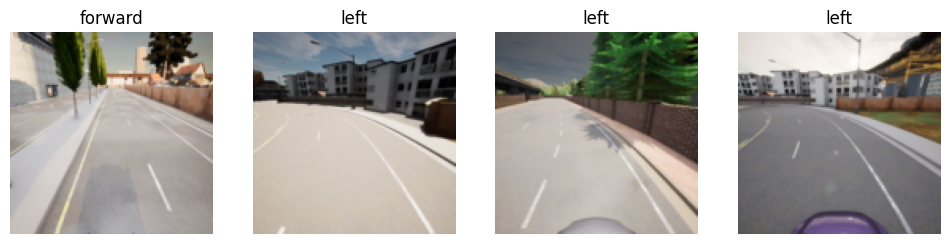

In [10]:

## instead of cropping

## we can pad the images

fruits = fruits.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)



## Squishing the images


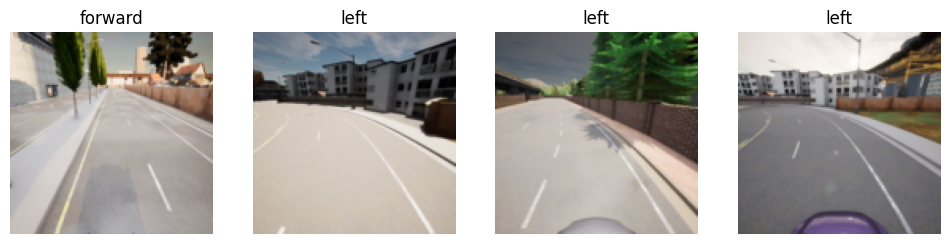

In [11]:

## or we can squish them

fruits = fruits.new(item_tfms=Resize(128, ResizeMethod.Squish))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)



## Random cropping of an image is considered better


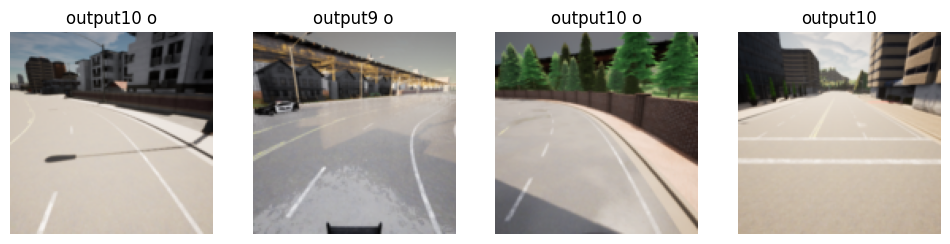

In [28]:

## random cropping of an image is considered better

fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


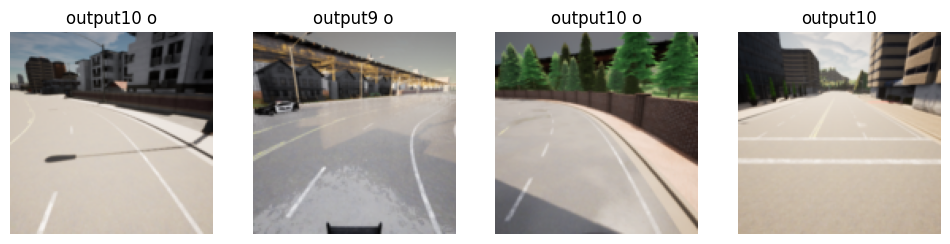

In [29]:

fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.5))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


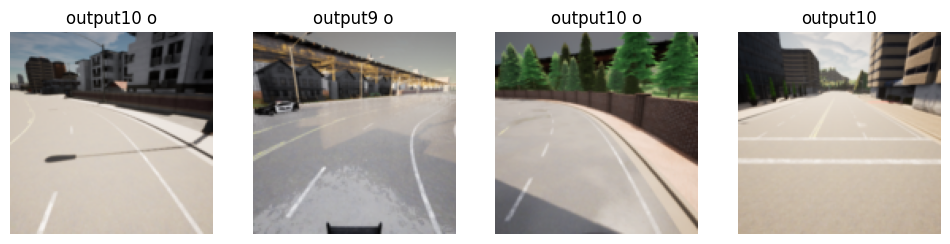

In [30]:

fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)



## Other data augmentation


In [31]:
print(len(dls.train.dataset))


3031


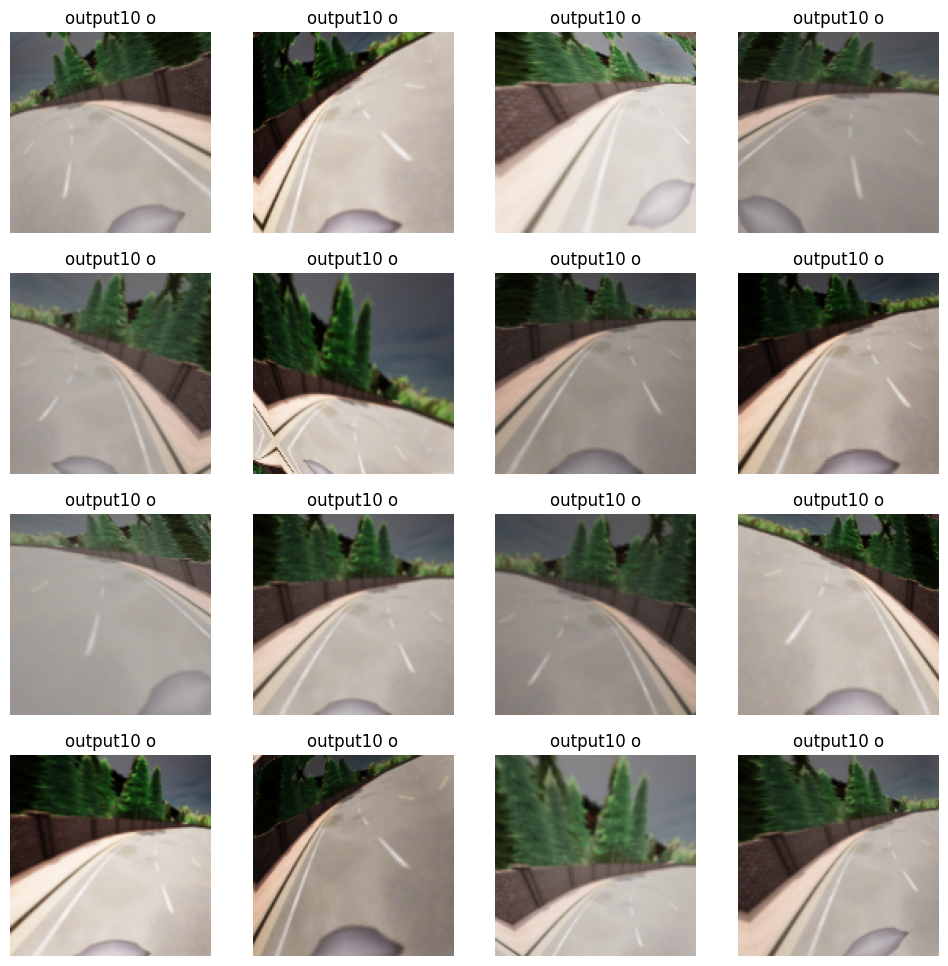

In [32]:
fruits = fruits.new(item_tfms=Resize(128), batch_tfms=aug_transforms(flip_vert=False, mult=2))  # Disable flipping
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=16, nrows=4, unique=True)

In [33]:

## data augmentation: rotation, flipping, perspective warping, contrast and brightness changes
## via GPU intensive batch_transforms

#fruits = fruits.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
#dls = fruits.dataloaders(path)
#dls.train.show_batch(max_n=16, nrows=4, unique=True)




## Fine Tune the pre-trained image classifier

* Here we use a CNN learner based on ResNet18

* CNN = Convolutional Neural Network


In [12]:

## now fine tune cnn_learner with our data

fruits = fruits.new(
     item_tfms=RandomResizedCrop(224, min_scale=0.5),
     batch_tfms=aug_transforms()
)

dls = fruits.dataloaders(  path  )

learn = cnn_learner(dls, resnet18, metrics=error_rate)    ## metrics=batch_accuracy, metrics=accuracy

learn.fine_tune(8)


D:\Users\Admin\anaconda3\Lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,0.814351,0.125867,0.054176,03:21


epoch,train_loss,valid_loss,error_rate,time
0,0.117841,0.013771,0.002257,04:25
1,0.074849,0.017285,0.002257,04:27
2,0.045391,0.004969,0.002257,04:26
3,0.030642,0.024329,0.002257,04:33
4,0.018342,0.023626,0.002257,07:29
5,0.013501,0.023365,0.002257,07:58
6,0.009744,0.021647,0.002257,04:59
7,0.008757,0.020843,0.002257,04:59



## Confusion Matrix


In [ ]:

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()


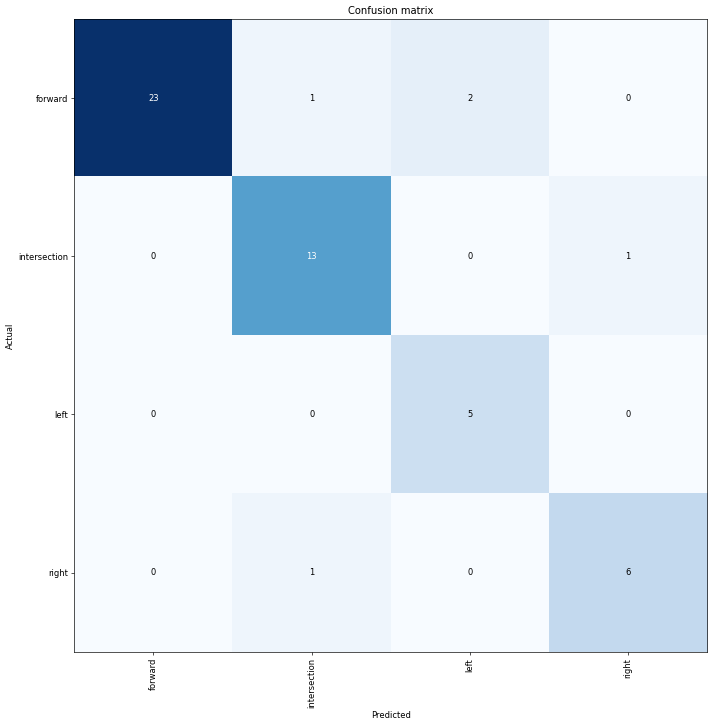

In [28]:

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)



## ML Performance Metrics


In [29]:

preds, y, losses = learn.get_preds(with_loss=True)


In [30]:

preds.shape


y_pred = torch.argmax(preds, dim=1)
y_pred.shape


torch.Size([52])

In [31]:

y.shape


torch.Size([52])

In [32]:

y_np       = y.numpy()
y_pred_np = y_pred.numpy()

accuracy = accuracy_score(y_np, y_pred_np)

f1 = f1_score(y_np, y_pred_np, average='weighted')

print(accuracy)
print(f1)


0.9038461538461539
0.906279885959689


In [33]:

learn.dls.vocab


['forward', 'intersection', 'left', 'right']

In [34]:

print(classification_report(y_np, y_pred_np))


              precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.87      0.93      0.90        14
           2       0.71      1.00      0.83         5
           3       0.86      0.86      0.86         7

    accuracy                           0.90        52
   macro avg       0.86      0.92      0.88        52
weighted avg       0.92      0.90      0.91        52



In [35]:

print(classification_report(y_np, y_pred_np, target_names=learn.dls.vocab))


              precision    recall  f1-score   support

     forward       1.00      0.88      0.94        26
intersection       0.87      0.93      0.90        14
        left       0.71      1.00      0.83         5
       right       0.86      0.86      0.86         7

    accuracy                           0.90        52
   macro avg       0.86      0.92      0.88        52
weighted avg       0.92      0.90      0.91        52




## Plot some losses


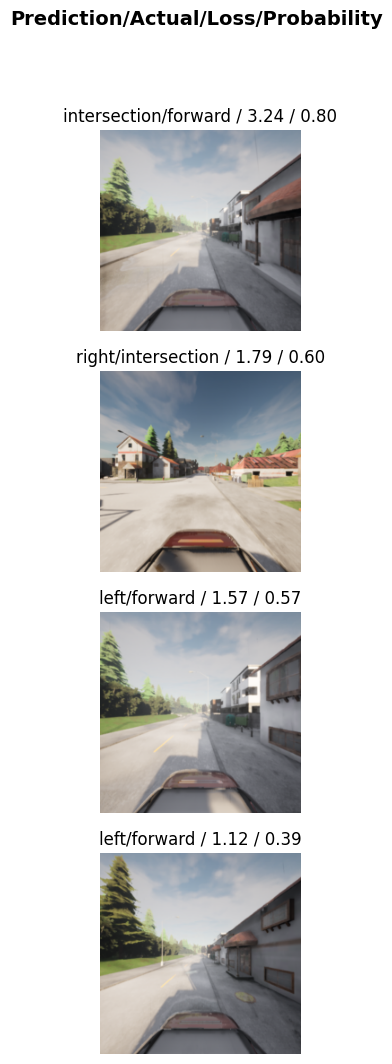

In [36]:

## plot_top_losses shows us the images with the highest loss in our dataset


interp.plot_top_losses(4, nrows=4)


In [10]:

## will save an export file called export.pkl to save the model


learn.export("carla_ModelLabels66.pkl")


In [6]:

## load_model from file


learn_inf = load_learner('carla_Model_v1.pkl')


NameError: name 'load_learner' is not defined

In [38]:

## load_model from file


learn_inf = load_learner('CIFAR10ModelLabels66.pkl')


In [39]:

img = 'gg.png'


is_plane, _, probs = learn_inf.predict(img)
print(is_plane)
print(probs)



right
tensor([0.1769, 0.2566, 0.1744, 0.3921])


In [8]:

is_plane, _, probs = learn_inf.predict(img)
print(is_plane)
print(probs)


metal
tensor([    0.0002,     0.0321,     0.9675,     0.0000,     0.0001,     0.0002])


In [31]:

learn_inf.dls.vocab


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

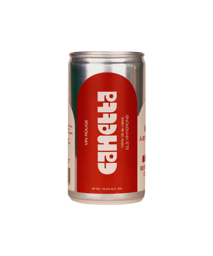

In [9]:

im = Image.open(img)
im.thumbnail((256,256))
im


In [10]:

learn.show_results()


NameError: name 'learn' is not defined

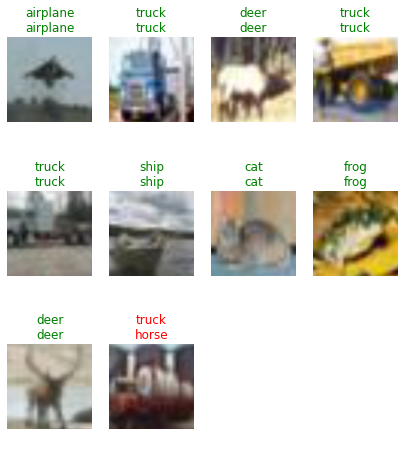

In [35]:

learn.show_results(max_n=10, figsize=(7, 8))


In [7]:
import sys

# Append path to the CARLA .egg file
sys.path.append('C:\\Users\\Admin\\Desktop\\CARLA_0.9.11\\WindowsNoEditor\\PythonAPI\\carla\\dist\\carla-0.9.11-py3.7-win-amd64.egg')

# Now you can import CARLA modules
import carla

# Connect to the Carla server
client = carla.Client('localhost',2000)
client.set_timeout(50.0)

# Load the world
world = client.get_world
#world = client.load_world('Town03')

ImportError: DLL load failed while importing libcarla: The specified module could not be found.

In [70]:


# Get the spectator
spectator = world.get_spectator()

# Get the location of the spectator
spectator_location = spectator.get_location()

# Define the blueprint of the car you want to spawn
car_blueprint = world.get_blueprint_library().find('vehicle.audi.a2')

# Specify the spawn location for the car as the spectator's location
spawn_point = carla.Transform(spectator_location, carla.Rotation(yaw=-90))

# Spawn the car
car = world.spawn_actor(car_blueprint, spawn_point)

# Wait for a while to let the car settle
world.wait_for_tick()

# Print the car's ID
print("Spawned car with ID:", car.id)

# Optionally, you can control the car or perform other actions here

# Define camera attributes
camera_transform = carla.Transform(carla.Location(x=1, y=0, z=3), carla.Rotation(pitch=0))

# Create camera blueprint
camera_blueprint = world.get_blueprint_library().find('sensor.camera.rgb')

camera_blueprint.set_attribute('sensor_tick', '0.1')
camera_blueprint.set_attribute('fov', '90')

# Create camera sensor and attach it to the vehicle
camera = world.spawn_actor(camera_blueprint, camera_transform, attach_to=car)


Spawned car with ID: 460


In [71]:
#car.set_autopilot(True)
def fu(image,car):
    image.save_to_disk('11.png')
    is_plane, _, probs = learn_inf.predict("11.png")
    #print(is_plane)
    if is_plane=="forward":
        car.apply_control(carla.VehicleControl(throttle=0.5, steer=0.0))  
        print("ff")
        
    if is_plane=="left":
        car.apply_control(carla.VehicleControl(throttle=0.5, steer=-0.1))    
        print("ff")

            
    if is_plane=="right":
        car.apply_control(carla.VehicleControl(throttle=0.5, steer=0.1))    
        print("ff")
    #spectator.set_transform(carla.Transform(camera.get_transform().location , camera.get_transform().rotation ))


import time
camera.listen(lambda image: fu(image,car))


# Let the simulation run for some time
time.sleep(20)

# Destroy the camera actor
camera.destroy()

ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


ff


False

ff


In [72]:
actors = world.get_actors()

# Iterate over actors and destroy vehicles
for actor in actors:
    if actor.type_id.startswith("vehicle"):
        actor.destroy()